In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from model import Net
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc, roc_auc_score

import os
import time

import sys
sys.path.append('..')
from data import train_gen, val_gen, test_gen, df_train, df_val, df_test, test_df, submit_test_gen

In [2]:
# load the model structure
model=Net()

# take a look what the model like
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Training

In [3]:
today=time.strftime('%Y%m%d')
if not os.path.exists(today):
    os.mkdir(today)

In [4]:
epochs=500

BATCH_SIZE=32

compute_steps_per_epoch=lambda x: int(np.ceil(1.*x/BATCH_SIZE))

steps_per_epoch=compute_steps_per_epoch(df_train.shape[0]) # number of steps in training / epoch
validation_steps=compute_steps_per_epoch(df_val.shape[0]) # number of steps in validation / epoch

es=EarlyStopping(monitor='val_loss',mode='min',verbose=2,patience=10)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=1,min_lr=1e-6)

prefix=today+'/'
mc=ModelCheckpoint(prefix+'best_model.h5',monitor='val_accuracy',
                   verbose=1,save_best_only=True,
                   save_weights_only=False,
                   model='auto'
                  )

In [5]:
history=model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=validation_steps,
                  epochs=epochs,
                  callbacks=[es,mc,reduce_lr]
                 )

Epoch 1/500
236/236 [==============================] - 73s 278ms/step - loss: 0.6367 - accuracy: 0.7054 - val_loss: 0.4242 - val_accuracy: 0.8055

Epoch 00001: val_accuracy improved from -inf to 0.80549, saving model to 20210820\best_model.h5
Epoch 2/500
236/236 [==============================] - 59s 249ms/step - loss: 0.4787 - accuracy: 0.7599 - val_loss: 0.4260 - val_accuracy: 0.8015

Epoch 00002: val_accuracy did not improve from 0.80549
Epoch 3/500
236/236 [==============================] - 59s 249ms/step - loss: 0.4620 - accuracy: 0.7751 - val_loss: 0.5274 - val_accuracy: 0.7375

Epoch 00003: val_accuracy did not improve from 0.80549
Epoch 4/500
236/236 [==============================] - 59s 249ms/step - loss: 0.4210 - accuracy: 0.7942 - val_loss: 0.4302 - val_accuracy: 0.7928

Epoch 00004: val_accuracy did not improve from 0.80549
Epoch 5/500
236/236 [==============================] - 59s 249ms/step - loss: 0.4116 - accuracy: 0.7997 - val_loss: 0.4141 - val_accuracy: 0.7936

Epoc

236/236 [==============================] - 59s 249ms/step - loss: 0.2719 - accuracy: 0.8805 - val_loss: 0.3300 - val_accuracy: 0.8580

Epoch 00038: val_accuracy did not improve from 0.86516
Epoch 39/500
236/236 [==============================] - 59s 249ms/step - loss: 0.2721 - accuracy: 0.8794 - val_loss: 0.3259 - val_accuracy: 0.8580

Epoch 00039: val_accuracy did not improve from 0.86516
Epoch 40/500
236/236 [==============================] - 59s 249ms/step - loss: 0.2706 - accuracy: 0.8776 - val_loss: 0.3348 - val_accuracy: 0.8572

Epoch 00040: val_accuracy did not improve from 0.86516

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 41/500
236/236 [==============================] - 59s 249ms/step - loss: 0.2642 - accuracy: 0.8840 - val_loss: 0.3262 - val_accuracy: 0.8628

Epoch 00041: val_accuracy did not improve from 0.86516
Epoch 42/500
236/236 [==============================] - 59s 249ms/step - loss: 0.2641 - accuracy: 0.8846 - val_loss: 0.

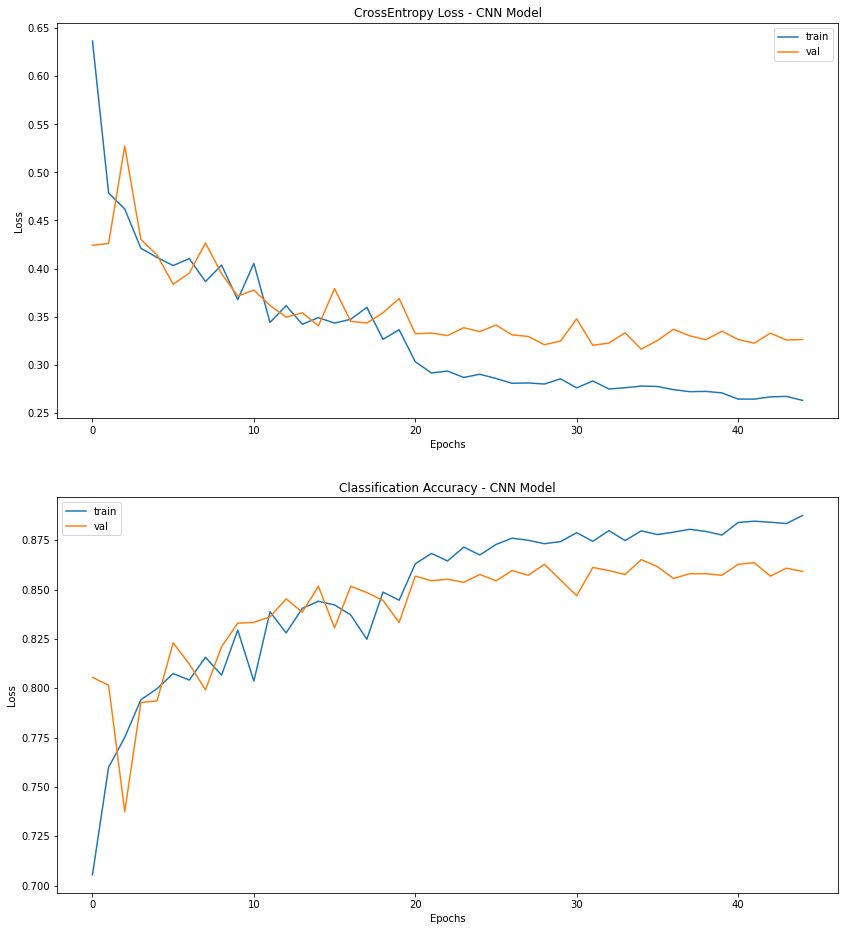

In [8]:
def history_plot(model_id,history):
    plt.figure(figsize=[14,16])
    
    # plot loss
    plt.subplot(2,1,1)
    
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    
    plt.legend()
    
    plt.title('CrossEntropy Loss - '+model_id)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # plot accuracy
    plt.subplot(2,1,2)
    
    plt.plot(history.history['accuracy'],label='train')
    plt.plot(history.history['val_accuracy'],label='val')
    
    plt.legend()
    
    plt.title('Classification Accuracy - '+model_id)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.show()
    
history.history.keys()

history_plot('CNN Model',history)

# Make Predictions on the set with known labels for evaluations

In [9]:
# Save results as CSV files

model.load_weights(prefix+'best_model.h5')

category_names=['No Defect','Defect']

y_test=df_test['defect_label']

STEP_SIZE_TEST=compute_steps_per_epoch(y_test.shape[0])


predictions=model.predict(test_gen,steps=STEP_SIZE_TEST,verbose=1)

y_pred=(predictions>0.5).astype('int32')

79/79 [==============================] - 6s 69ms/step


In [10]:
# Evalutions
# ------------

# (I) classification report

report_string=classification_report(y_test,y_pred,target_names=category_names)
print(report_string)

              precision    recall  f1-score   support

   No Defect       0.87      0.85      0.86      1181
      Defect       0.87      0.88      0.88      1333

    accuracy                           0.87      2514
   macro avg       0.87      0.87      0.87      2514
weighted avg       0.87      0.87      0.87      2514



ROC AUC=0.940


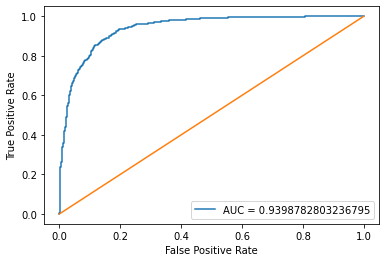

In [11]:
# (II) AUC

# calculate scores
auc=roc_auc_score(y_test,predictions)

#summarize scores
print('ROC AUC=%.3f' % auc)

ns_fpr, ns_tpr, _= roc_curve(y_test,predictions)
# fpr='false positive rate'
# tpr='true positive rate'

# plot the roc curve for the model
plt.plot(ns_fpr,ns_tpr,label='AUC = '+str(auc))
plt.plot([0,1],[0,1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

# If satisfied, make prediction on the real test set to determine whether images there contain defects 

In [12]:
# save the satifised model
model.save('VGG2classes.h5',save_format='h5')

In [15]:
STEP_SIZE_TEST=compute_steps_per_epoch(test_df.shape[0])

# make prediction
submit_test=model.predict(submit_test_gen,
                          steps=STEP_SIZE_TEST,
                          verbose=1
                         )

test_df['defect_label']=(submit_test>0.5).astype('int32')

test_df.head()

173/173 [==============================] - 26s 149ms/step


,ImageId,defect_label
0,0000f269f.jpg,1
1,000ccc2ac.jpg,1
2,002451917.jpg,1
3,003c5da97.jpg,0
4,0042e163f.jpg,1


In [16]:
# see the statistics of the test predictions
test_df['defect_label'].value_counts()


1    3674
0    1832
Name: defect_label, dtype: int64

In [18]:
# save the test results to csv file

pd.DataFrame(history.history).to_csv(
    'CNN_VGG_history.csv',index=False)

# df.to_csv('train_CNN_VGG.csv',index=False)
test_df.to_csv('test_CNN_VGG.csv',index=False)
